## Plot all-sky satellite locations

In [1]:
import numpy as np
import pylab as plt
import ephem
from datetime import datetime
import pandas as pd
from astropy.coordinates import Angle
from astropy.time import Time
from dateutil import parser as dparser

### Load TLE data from file

In [2]:
tle_filename = 'tles_180301.txt'
with open(tle_filename) as tle_file:
    tle_data = tle_file.read().splitlines()

sat_list = []
for ii in range(0, len(tle_data), 3):
    sat_list.append(ephem.readtle(*tle_data[ii:ii+3]))

### Create FRB event and setup ephem.Observer

In [3]:
# Create FRB ephem source
frbline = "FRB180301    2018/03/01 07:34:19.760   Parkes    06:12:43.4     04:33:44.8"

name, date, time, telescope, ra, dec = frbline.split()
frb_time = dparser.parse(date +' ' + time)
frb_ra   = Angle(ra, unit='hourangle')
frb_dec  = Angle(dec, unit='degree')

# Create Ephem observer
pks = ephem.Observer()
pks.lon = '148:15:48.6'
pks.lat = '-32:59:54.3'
pks.date = frb_time

# Create FRB as fixedBody source
frb = ephem.FixedBody()
frb._ra  = frb_ra.to('radian').value
frb._dec = frb_dec.to('radian').value
frb.compute(pks)
frb_az = Angle(float(frb.az), unit='radian').to('degree')
frb_alt = Angle(float(frb.alt), unit='radian').to('degree')
frb_elev = Angle(90, unit='degree') - frb_alt

print "--- FRB 180301 --- "
print " UTC:      ", pks.date
print " RA, DEC:  ", frb.ra, frb.dec 
print " ALT, AZ:  ", frb.alt, frb.az, '\n'

--- FRB 180301 --- 
 UTC:       2018/3/1 07:34:20
 RA, DEC:   6:13:41.02 4:33:12.0
 ALT, AZ:   41:27:07.3 45:37:04.9 



### Compute satellite locations

In [4]:
# Compute satellite locations at each datetime
sat_loc = {
    'alt_rad': np.zeros(len(sat_list)),
    'az_rad': np.zeros(len(sat_list)),
    'za_rad': np.zeros(len(sat_list)),
    'ra_ha': np.zeros(len(sat_list)),
    'dec_deg': np.zeros(len(sat_list)),
    'name': np.empty(len(sat_list), dtype='|S16')
}

for ii, sat in enumerate(sat_list):
    sat.compute(pks)
    sat_loc['za_rad'][ii] = np.pi / 2 - sat.alt
    sat_loc['alt_rad'][ii]  = sat.alt
    sat_loc['az_rad'][ii]   = sat.az
    sat_loc['ra_ha'][ii]    = sat.ra / 2 / np.pi * 24
    sat_loc['dec_deg'][ii]  = sat.dec / np.pi / 2 * 360
    sat_loc['name'][ii]     = sat.name
    
# Generate a pandas dataframe
df = pd.DataFrame.from_dict(sat_loc)
df = df[['name', 'ra_ha', 'dec_deg', 'az_rad', 'alt_rad', 'za_rad']] # Rearrange columns

### Plot all-sky orthographic projection

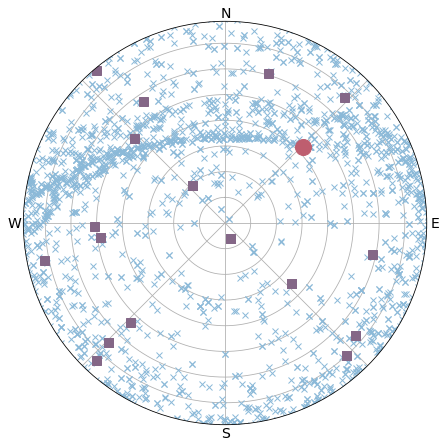

In [10]:
# Select out GPS and other constellations
gps    = df[df['name'].str.contains('NAVSTAR')]
beidou = df[df['name'].str.contains('BEI')]
galileo = df[df['name'].str.contains('GALI')]

# Plot satellite track in polar coordinates -- setup
#plt.figure(figsize=(10, 10))
plt.figure(figsize=(6, 6))
ax = plt.subplot(111,projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
thetagrids = range(0,360,10)

# Do plotting
plt.polar(df['az_rad'], df['za_rad'], 'x', c='#8bb9d8', markersize=6, label='All')
plt.polar(frb_az.to('radian').value, frb_elev.to('radian').value, 'o', color='#be5e6f', markersize=16, label='FRB 180301')
plt.polar(gps['az_rad'], gps['za_rad'], 's', markersize=9, c='#846787', label='GPS')

# Setup axes and formatting
plt.ylim(0,np.pi/2) # Restrict to above horizon
#plt.title("Satellite locations during %s" % name)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4], ["", "", "", "", "", "", ""] )
plt.xticks(np.deg2rad(np.linspace(0, 360, 9)[:-1]), ["", "", "", "", "", "", "", "", ""])

ax.text(0.49, 1.01, 'N', transform=ax.transAxes, fontsize=14)
ax.text(0.49, -0.03, 'S', transform=ax.transAxes, fontsize=14)
ax.text(1.01, 0.49, 'E', transform=ax.transAxes, fontsize=14)
ax.text(-0.04, 0.49, 'W', transform=ax.transAxes, fontsize=14)

plt.tight_layout()
plt.savefig("sat-pos-allsky.pdf")
plt.show()